In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# source - IHME GBD 2019
df_alcohol = pd.read_csv("alcohol_use_disorders.csv")

# source - The World Bank Global Financial Development
df_risk = pd.read_csv("stock_price_volatility_g7.csv")

# source - WHO Age-Standardized Suicide Rates per 100,000 population
df_suicide = pd.read_csv("suicide.csv")

# source - OECD Data(https://data.oecd.org/healthrisk/social-support.htm)
df_social = pd.read_csv("social_support.csv")

### Data Preperation

In [3]:
df_risk = df_risk.drop(["Series Name", "Country Code"], axis = 1)
df_risk = df_risk.rename(columns={"Country Name": "Country"})
df_risk.loc[2, "Country"] = "South Korea"

In [4]:
# Rename year for df_risk

year_index = {}
year_list = []

for i_year in range(1990, 2022):
    year_list.append(i_year)

for year in year_list:
    target_index = f"{year}"+" [YR"+f"{year}"+"]"
    year_index[target_index] = year
    
df_risk = df_risk.rename(columns=year_index)
df_risk = df_risk.sort_values("Country")

In [5]:
alcohol_code = "Current number of cases of alcohol use disorders per 100 people, in both sexes aged age-standardized"
df_alcohol = df_alcohol.rename(columns={"Entity": "Country", alcohol_code: "Alcohol"})
df_alcohol = df_alcohol.drop(["Code"], axis = 1)

In [6]:
# Select Countries for df_alcohol
country_index = []
country_list = list(df_risk["Country"].unique())
for i_country in range(6840):
    if df_alcohol["Country"][i_country] in country_list:
        country_index.append(i_country)

In [7]:
# Change df_alcohol to DataFrame containing target countries only
df_alc = pd.DataFrame()
for col_name in ["Country", "Year", "Alcohol"]:
    df_alc[col_name] = list(df_alcohol.loc[country_index, col_name])
df_alcohol = df_alc

In [8]:
# Handling Missing Values

df_alcohol.isna().any()
df_risk.isna().sum()
df_suicide.isna().any()
df_social.isna().any()

# Fill Missing Values

df_risk = df_risk.fillna(df_risk.loc[df_risk["Country"]=="Italy"].transpose()[4][9:].mean())
df_social = df_social.transpose().fillna(method="ffill").transpose()

In [9]:
# Organize row orders

df_social = df_social.sort_values("Country")
df_suicidie = df_suicide.sort_values("Country")

In [10]:
# Make time series form of df_alcohol
df_alc_t = pd.DataFrame()
year_list = []

df_alc_t["Country"] = country_list

for i_year in range(1990, 2020):
    year_list.append(i_year)
    
for j_year in year_list:
    df_alc_t[str(j_year)] = list(df_alcohol.loc[df_alcohol["Year"]==j_year, "Alcohol"])
    
df_alcohol_t = df_alc_t

In [11]:
# Make normal form of df_alcohol
index = {}
count = 0

df_alcohol = df_alcohol_t.transpose()

for i_index_2 in range(8):
    index[i_index_2] = country_list[count]
    count += 1
    
df_alcohol = df_alcohol.rename(columns=index)
df_alcohol = df_alcohol.drop(["Country"], axis=0)

In [12]:
# Make normal form and time series form of df_risk

df_risk_t = df_risk

index_list = [5, 6, 3, 4, 0, 2, 7, 1]
index = {}
count = 0

df_risk = df_risk_t.transpose()
for i_index in index_list:
    index[i_index] = country_list[count]
    count += 1
    
df_risk = df_risk.rename(columns=index)
df_risk = df_risk.drop(["Country"], axis=0)

In [13]:
# Make normal form and time series form of df_suicide

df_suicide_t = df_suicide

df_suicide = df_suicide_t.transpose()

index_list = list(range(0,8))
index = {}
count = 0

for i_index in index_list:
    index[i_index] = country_list[count]
    count += 1

df_suicide = df_suicide.rename(columns=index).drop(["Country"], axis=0)

In [14]:
# Make normal form and time series form of df_social

df_social_t = df_social

df_social = df_social_t.transpose()

df_social = df_social.rename(columns=index).drop(["Country"], axis=0)

In [15]:
# Adjust Index DataTypes

attributes = ["Risk", "Alcohol", "Suicide", "Social"]
for attr in attributes:
    attr = attr.lower()
    exec(f"df_{attr}.index = df_{attr}.index.astype(int)", globals())

#### Now we have eight dataframes; 
1. Normal Form: df_alcohol, df_risk, df_suicide, df_social
2. Time Series Form: df_alcohol_t, df_risk_t, df_suicide_t, df_social_t

#### Using these, we are going to build the main DataFrame, named df

In [16]:
df = pd.DataFrame()

In [17]:
# Make Year Column
years = range(2006, 2020)
year_list = []
for year in years:
    for rep in range(len(country_list)):
        year_list.append(year)
df["Year"] = year_list

In [18]:
# Make Country Column
country_list_df = []
for rep in range(len(range(2006, 2020))):
    for country in country_list:
        country_list_df.append(country)
df["Country"] = country_list_df

In [19]:
# Make Attributes Column
for attr in attributes:
    df[attr] = 0

In [20]:
# Fill Attributes Column

def Column_Filler(attribute):
    for country in country_list:
        exec(f"filler = list(df_{attribute.lower()}.loc[2006:2019, '{country}'])", globals())
        df.loc[df["Country"]==country, attribute] = filler

for attr in attributes:
    Column_Filler(attr)

### Data Exploration

In [21]:
# change graph display settings
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(font_scale=1.3)
sns.set_style("ticks")

In [22]:
# Overall Distribution

df.describe()

,Year,Risk,Alcohol,Suicide,Social
count,112.000000,112.000000,112.000000,112.000000,112.000000
mean,2012.500000,18.754922,2.020492,12.008929,90.033755
std,4.049246,7.300668,0.753009,5.659236,5.378118
min,2006.000000,8.210422,0.555090,4.300000,72.365741
25%,2009.000000,13.144823,1.688589,8.175000,88.648882
50%,2012.500000,17.326665,2.047323,10.600000,91.441275
75%,2016.000000,22.938600,2.341037,14.100000,93.516947
max,2019.000000,39.573030,3.235323,28.800000,97.702978


<AxesSubplot:>

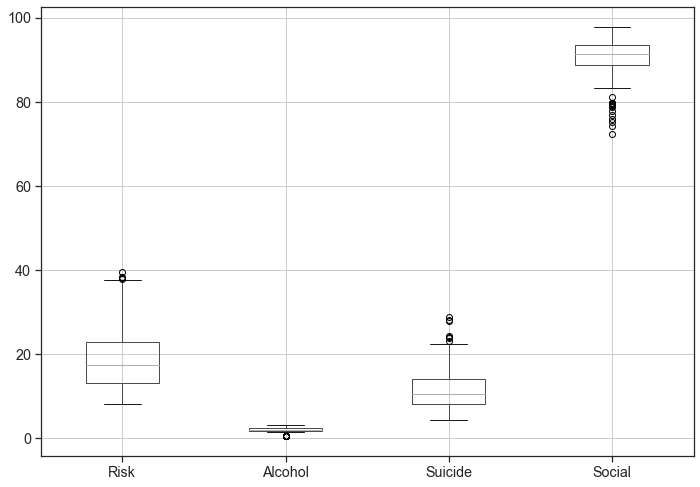

In [23]:
df.boxplot(column = attributes)

<AxesSubplot:xlabel='Year'>

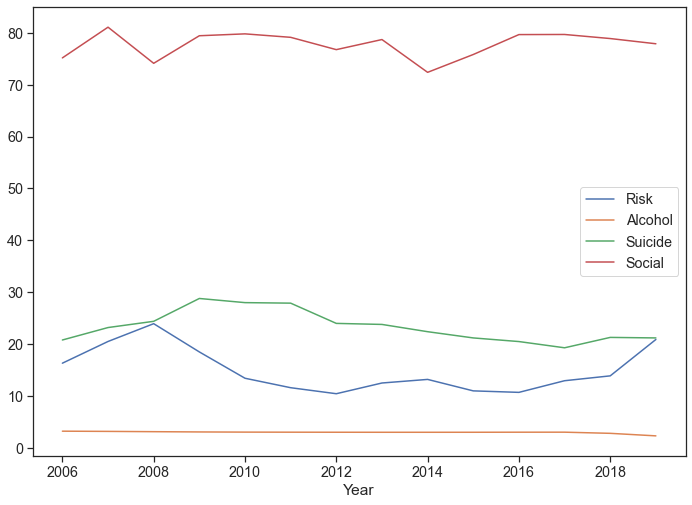

In [24]:
# Change over time

df.loc[df["Country"]=="South Korea"].plot.line(x="Year")

<AxesSubplot:xlabel='Country'>

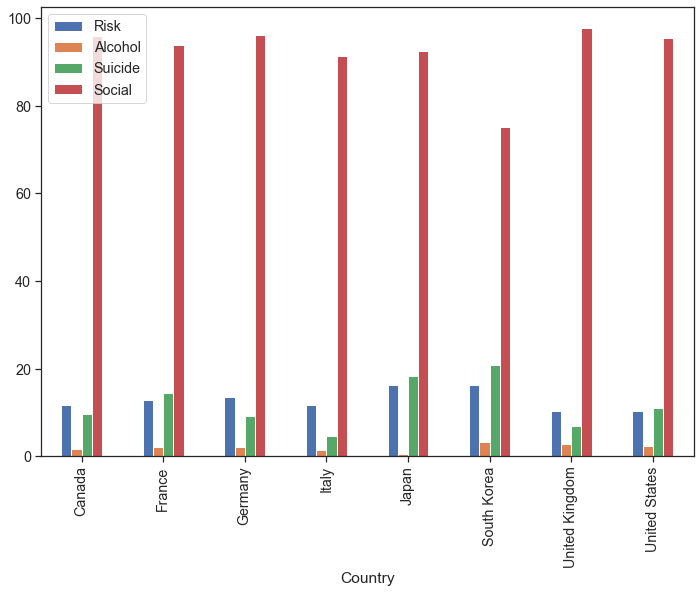

In [25]:
# Countrywise Comparison

df.loc[df["Year"]==2006].plot.bar(x = "Country", y = attributes)

#### Correlation Analysis

In [26]:
# Correlation Analysis

attributes_corr = attributes[1:]

for attr in attributes_corr:
    corr = df[["Risk", attr]].corr().loc["Risk", attr]
    print(attr+":", corr)

Alcohol: -0.2986015283320355
Suicide: -0.1312161839045365
Social: 0.058699853348999756


In [27]:
df[attributes_corr].describe()

,Alcohol,Suicide,Social
count,112.000000,112.000000,112.000000
mean,2.020492,12.008929,90.033755
std,0.753009,5.659236,5.378118
min,0.555090,4.300000,72.365741
25%,1.688589,8.175000,88.648882
50%,2.047323,10.600000,91.441275
75%,2.341037,14.100000,93.516947
max,3.235323,28.800000,97.702978


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='Alcohol', ylabel='Risk'>

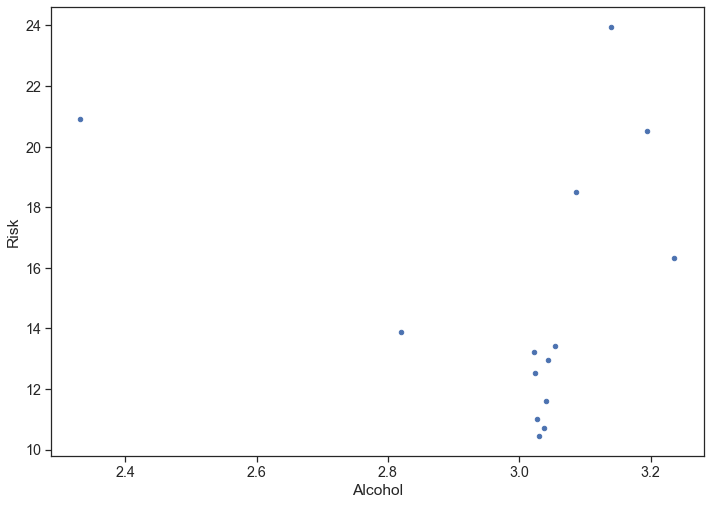

In [28]:
df.loc[df["Country"]=="South Korea"].plot.scatter(x="Alcohol", y="Risk")

<AxesSubplot:xlabel='Alcohol', ylabel='Risk'>

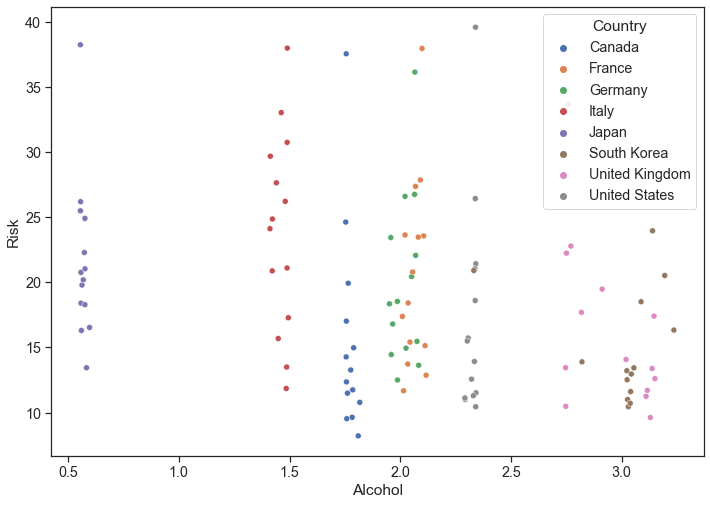

In [29]:
sns.scatterplot(x = "Alcohol", y = "Risk", hue = "Country", data = df)

<AxesSubplot:xlabel='Social', ylabel='Risk'>

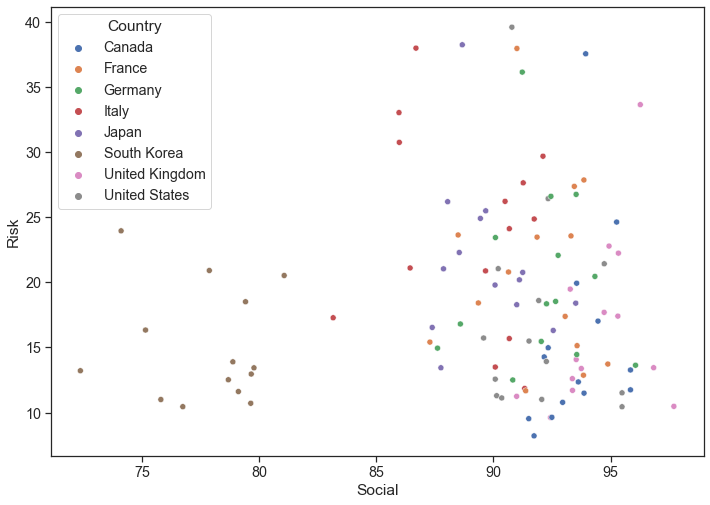

In [30]:
sns.scatterplot(x = "Social", y = "Risk", hue = "Country", data = df)

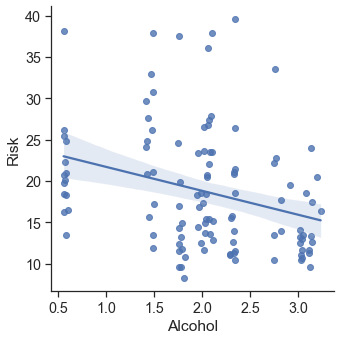

In [31]:
sns.lmplot(x = "Alcohol", y = "Risk", data = df)

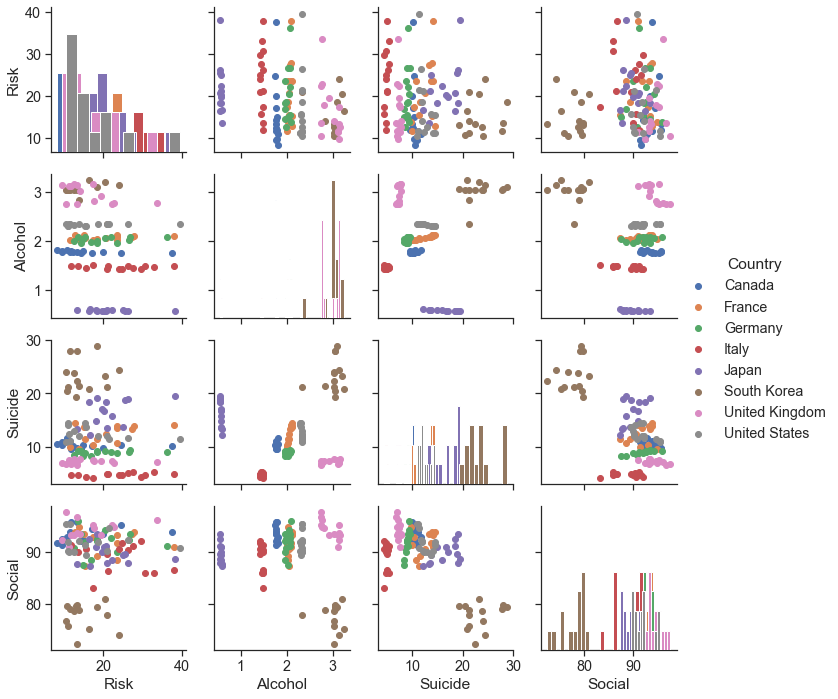

In [32]:
# Pairwise Relationships

attributes_pair = attributes[:]
attributes_pair.append("Country")

grid = sns.PairGrid(df[attributes_pair], hue = "Country")
grid.map_diag(plt.hist)
grid.map_offdiag(plt.scatter)

grid.add_legend()